In [ ]:
import numpy
import os
import pandas as pd
import tensorflow as tf
from keras.layers import LSTM
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GRU
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import matplotlib.pyplot as plt
import time

In [ ]:
text = open('dataset.txt', 'rb').read().decode(encoding='utf-8')
text = text.lower()
print(f'Length of text: {len(text)} characters')

Length of text: 1107542 characters


In [ ]:
print(text[:500])

harry potter and the goblet of fire

chapter one - the riddle house

	the villagers of little hangleron still called it "the riddle house," even though it had been many years since the riddle family had lived there.  it stood on a hill overlooking the village, some of its windows boarded, tiles missing from its roof, and ivy spreading unchecked over its face.  once a fine-looking manor, and easily the largest and grandest building for miles around, the riddle house was now damp, derelict, and un


In [ ]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

54 unique characters


# Text operation functions

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1107542,), dtype=int64, numpy=array([33, 26, 43, ..., 29, 11,  2])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(12):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

h
a
r
r
y
 
p
o
t
t
e
r


# Creating dataset

In [ ]:
seq_length = 100
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'harry potter and the goblet of fire\n\nchapter one - the riddle house\n\n\tthe villagers of little hangler'
b'on still called it "the riddle house," even though it had been many years since the riddle family had'
b' lived there.  it stood on a hill overlooking the village, some of its windows boarded, tiles missing'
b' from its roof, and ivy spreading unchecked over its face.  once a fine-looking manor, and easily the'
b' largest and grandest building for miles around, the riddle house was now damp, derelict, and unoccup'


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
dataset = sequences.map(split_input_target)
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'harry potter and the goblet of fire\n\nchapter one - the riddle house\n\n\tthe villagers of little hangle'
Target: b'arry potter and the goblet of fire\n\nchapter one - the riddle house\n\n\tthe villagers of little hangler'


#Creating Batches

In [ ]:

BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class Model(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.lstm = GRU(rnn_units, return_sequences=True, return_state=True)
    self.dense = Dense(vocab_size)
    self.dense2 = Dense(1, activation = 'softmax')

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.lstm.get_initial_state(x)
    x, states = self.lstm(x, initial_state=states, training=training)
    x = self.dense(x, training=training)
    
    if return_state:
      return x, states
    else:
      return x

In [ ]:
model1 = Model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model1.compile(optimizer='adam', loss=loss, metrics = 'accuracy')


In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
trained_model1 = model1.fit(dataset, epochs=30 , callbacks=[checkpoint_callback])

Epoch 1/30
171/171 [==============================] - 16s 52ms/step - loss: 2.6092 - accuracy: 0.2871
Epoch 2/30
171/171 [==============================] - 10s 52ms/step - loss: 1.9231 - accuracy: 0.4328
Epoch 3/30
171/171 [==============================] - 10s 53ms/step - loss: 1.5789 - accuracy: 0.5268
Epoch 4/30
171/171 [==============================] - 10s 54ms/step - loss: 1.3902 - accuracy: 0.5786
Epoch 5/30
171/171 [==============================] - 10s 54ms/step - loss: 1.2818 - accuracy: 0.6064
Epoch 6/30
171/171 [==============================] - 10s 55ms/step - loss: 1.2090 - accuracy: 0.6255
Epoch 7/30
171/171 [==============================] - 10s 54ms/step - loss: 1.1521 - accuracy: 0.6404
Epoch 8/30
171/171 [==============================] - 10s 52ms/step - loss: 1.1047 - accuracy: 0.6531
Epoch 9/30
171/171 [==============================] - 10s 53ms/step - loss: 1.0609 - accuracy: 0.6651
Epoch 10/30
171/171 [==============================] - 10s 54ms/step - loss: 1.019

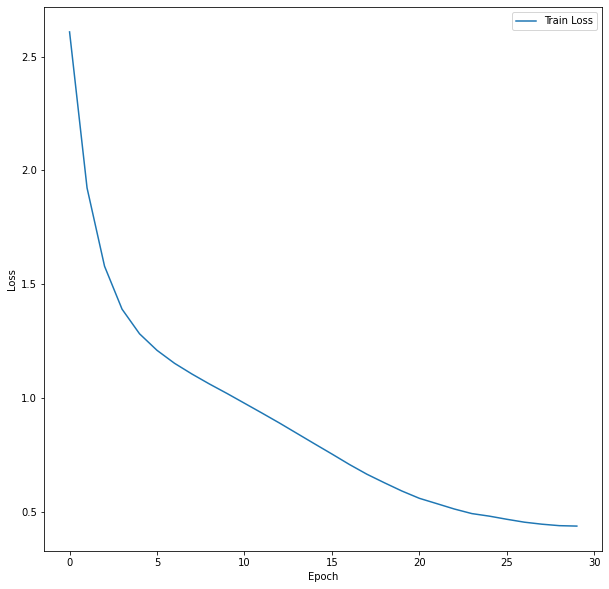

In [ ]:
fig_Loss = plt.figure(figsize=(10, 10))
plt.plot(trained_model1.history['loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss"])
plt.show()
#fig_Loss.savefig("Loss_Model.png")

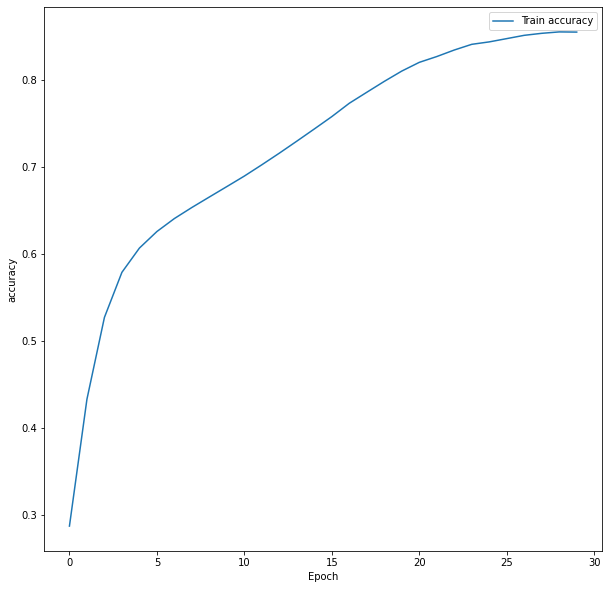

In [ ]:
fig_Loss = plt.figure(figsize=(10, 10))
plt.plot(trained_model1.history['accuracy'])
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(["Train accuracy"])
plt.show()


In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor( values=[-float('inf')]*len(skip_ids), indices=skip_ids, dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):

    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    predicted_logits, states = self.model(inputs=input_ids, states=states,  return_state=True)
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    predicted_logits = predicted_logits + self.prediction_mask

    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)
    predicted_chars = self.chars_from_ids(predicted_ids)
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model1, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['harry'])
result = [next_char]

for n in range(200):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

harry savage quickly and the others, writes rita skeeter as we appeared to be a dementor, quite as usual.  he was still gazing at the entrance hall, with her teary again unlikely than the boy 'bottee that  

________________________________________________________________________________

Run time: 1.2556376457214355


# Loss function

In [ ]:
"""model2 = Model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)"""

'model2 = Model(\n    vocab_size=vocab_size,\n    embedding_dim=embedding_dim,\n    rnn_units=rnn_units)'

In [ ]:
"""loss =  tf.keras.losses.KLDivergence()
model2.compile(optimizer='adam', loss=loss, metrics = 'accuracy')"""

"loss =  tf.keras.losses.KLDivergence()\nmodel2.compile(optimizer='adam', loss=loss, metrics = 'accuracy')"

In [ ]:
"""history2 = model2.fit(dataset, epochs=2 , callbacks=[checkpoint_callback])"""

'history2 = model2.fit(dataset, epochs=2 , callbacks=[checkpoint_callback])'

#epochs

In [ ]:
model4 = Model(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units)

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model4.compile(optimizer='adam', loss=loss, metrics = 'accuracy')
trained_model4 = model4.fit(dataset, epochs=60 , callbacks=[checkpoint_callback])

Epoch 1/60
171/171 [==============================] - 12s 55ms/step - loss: 2.5957 - accuracy: 0.2886
Epoch 2/60
171/171 [==============================] - 10s 53ms/step - loss: 1.9112 - accuracy: 0.4366
Epoch 3/60
171/171 [==============================] - 10s 54ms/step - loss: 1.5715 - accuracy: 0.5285
Epoch 4/60
171/171 [==============================] - 10s 54ms/step - loss: 1.3824 - accuracy: 0.5792
Epoch 5/60
171/171 [==============================] - 10s 54ms/step - loss: 1.2762 - accuracy: 0.6076
Epoch 6/60
171/171 [==============================] - 10s 54ms/step - loss: 1.2060 - accuracy: 0.6263
Epoch 7/60
171/171 [==============================] - 10s 54ms/step - loss: 1.1508 - accuracy: 0.6407
Epoch 8/60
171/171 [==============================] - 10s 54ms/step - loss: 1.1033 - accuracy: 0.6536
Epoch 9/60
171/171 [==============================] - 10s 54ms/step - loss: 1.0595 - accuracy: 0.6653
Epoch 10/60
171/171 [==============================] - 10s 54ms/step - loss: 1.016

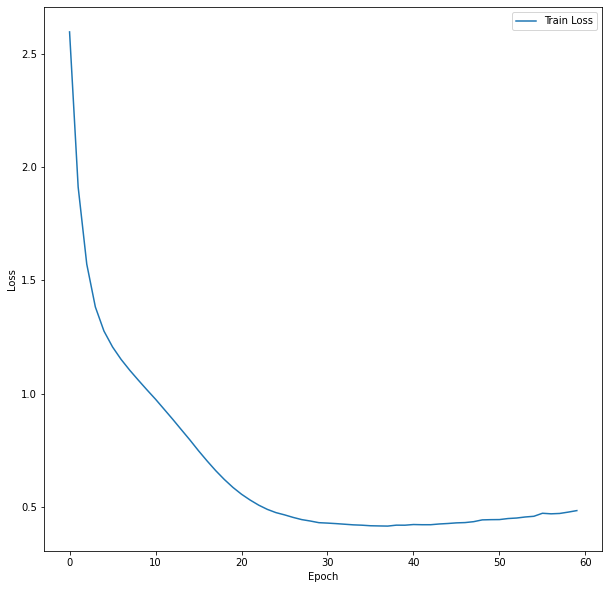

In [ ]:
fig_Loss = plt.figure(figsize=(10, 10))
plt.plot(trained_model4.history['loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss"])
plt.show()
#fig_Loss.savefig("Loss_Model.png")

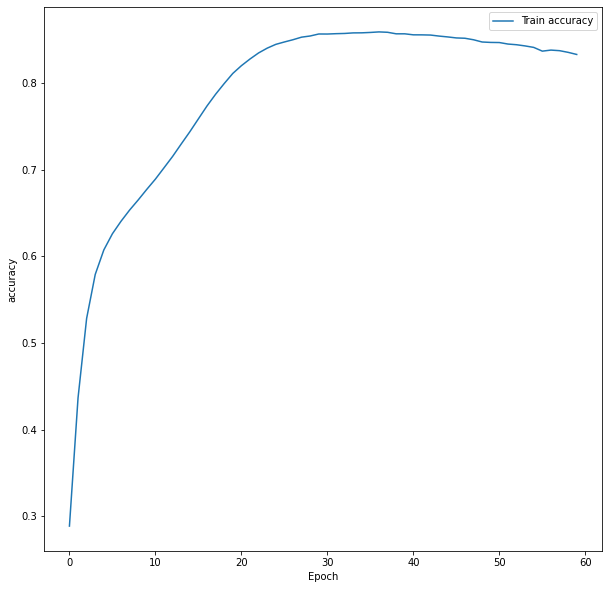

In [ ]:
fig_Loss = plt.figure(figsize=(10, 10))
plt.plot(trained_model4.history['accuracy'])
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(["Train accuracy"])
plt.show()


In [ ]:
start = time.time()
one_step_model4 = OneStep(model4, chars_from_ids, ids_from_chars)
states = None
next_char = tf.constant(['harry'])
result = [next_char]

for n in range(200):
  next_char, states = one_step_model4.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

harry potter!"
dumbledore stood shrieked in out of the portrait hole.  perhaps she'd have said him until harry, ron, and hermione turred.
"well, it was you, lake, potter?  a few days ago - i want to give y 

________________________________________________________________________________

Run time: 1.3043649196624756


#optimzer

In [ ]:
model5 = Model(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units)
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model5.compile(optimizer='SGD', loss=loss, metrics = 'accuracy')
trained_model5 = model5.fit(dataset, epochs=30 , callbacks=[checkpoint_callback])

Epoch 1/30
171/171 [==============================] - 12s 51ms/step - loss: 3.8563 - accuracy: 0.1721
Epoch 2/30
171/171 [==============================] - 10s 52ms/step - loss: 3.5157 - accuracy: 0.1774
Epoch 3/30
171/171 [==============================] - 10s 53ms/step - loss: 3.2314 - accuracy: 0.1774
Epoch 4/30
171/171 [==============================] - 10s 53ms/step - loss: 3.1126 - accuracy: 0.1774
Epoch 5/30
171/171 [==============================] - 10s 52ms/step - loss: 3.0699 - accuracy: 0.1774
Epoch 6/30
171/171 [==============================] - 10s 52ms/step - loss: 3.0471 - accuracy: 0.1774
Epoch 7/30
171/171 [==============================] - 10s 51ms/step - loss: 3.0340 - accuracy: 0.1774
Epoch 8/30
171/171 [==============================] - 10s 51ms/step - loss: 3.0257 - accuracy: 0.1774
Epoch 9/30
171/171 [==============================] - 10s 52ms/step - loss: 3.0196 - accuracy: 0.1774
Epoch 10/30
171/171 [==============================] - 10s 52ms/step - loss: 3.014

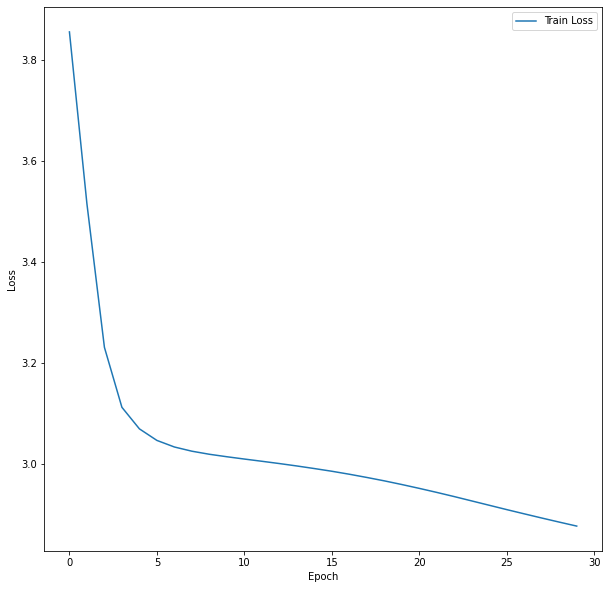

In [ ]:
fig_Loss = plt.figure(figsize=(10, 10))
plt.plot(trained_model5.history['loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss"])
plt.show()
#fig_Loss.savefig("Loss_Model.png")

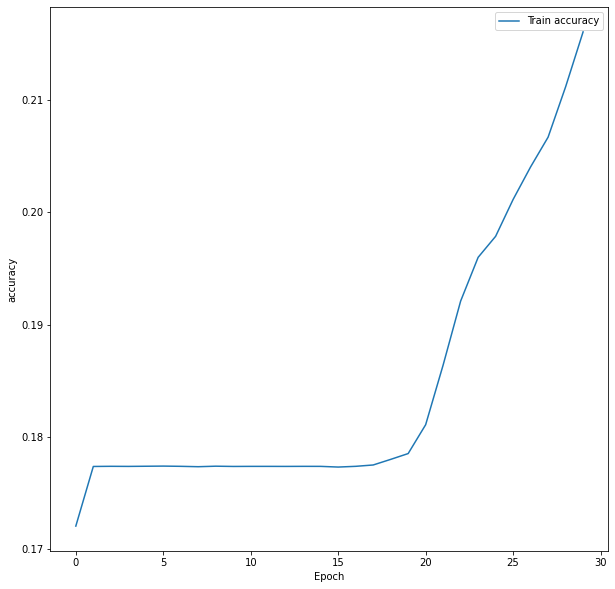

In [ ]:
fig_Loss = plt.figure(figsize=(10, 10))
plt.plot(trained_model5.history['accuracy'])
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(["Train accuracy"])
plt.show()


In [ ]:
start = time.time()
one_step_model5 = OneStep(model5, chars_from_ids, ids_from_chars)
states = None
next_char = tf.constant(['harry'])
result = [next_char]

for n in range(200):
  next_char, states = one_step_model5.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

harry t gkwaonoep ,t retietd "fvradu e oee q asd tcbynsttdi h s eo w .lyoee lbh trugst,ar nhler .eh tcbeyby thdr hrd,nr fdee t.sedoe.h ne arr msew h itheeld erhebaayoe ln thut eadsedirtb aghrnucaw hluwedor 

________________________________________________________________________________

Run time: 1.1105434894561768
